# Adaptive RAG

----

Adaptive RAG predicts the **complexity of the input question** using a SLM/LLM and selects an appropriate processing workflow accordingly.

- **Very simple question (No Retrieval)**: Generates answers without RAG.
- **Simple question (Single-shot RAG)**: Efficiently generates answers through a single-step search and generation.
- **Complex question (Iterative RAG)**: Provides accurate answers to complex questions through repeated multi-step search and generation.


Adaptive-RAG, Self-RAG, and Corrective RAG are similar approach, but they have different focuses.

- **Adaptive-RAG**: Dynamically selects appropriate retrieval and generation strategies based on the complexity of the question.
- **Self-RAG**: The model determines the need for retrieval on its own, performs retrieval when necessary, and improves the quality through self-reflection on the generated answers.
- **Corrective RAG**: Evaluates the quality of retrieved documents, and performs additional retrievals such as web searches to supplement the information if the reliability is low.

**Reference**

- [Adaptive-RAG paper](https://arxiv.org/abs/2403.14403)  

In [8]:
from dotenv import load_dotenv
import os
import json
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizableTextQuery
from azure.ai.evaluation import GroundednessEvaluator, RelevanceEvaluator, RetrievalEvaluator
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_core.models import ChatCompletionClient, SystemMessage, UserMessage, AssistantMessage
from autogen_core import MessageContext, RoutedAgent, SingleThreadedAgentRuntime, TopicId, message_handler, type_subscription
from pydantic import BaseModel
from typing import List
from dataclasses import dataclass


load_dotenv(override=True)

True

In [9]:
# Get the environment variables
azure_ai_search_endpoint = os.getenv("AZURE_AI_SEARCH_ENDPOINT")
search_credential = AzureKeyCredential(os.getenv("AZURE_AI_SEARCH_API_KEY", "")) if len(os.getenv("AZURE_AI_SEARCH_API_KEY", "")) > 0 else DefaultAzureCredential()
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME", "hotels-sample-index")

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY", "") if len(os.getenv("AZURE_OPENAI_API_KEY", "")) > 0 else None
azure_openai_chat_deployment_name = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_embedding_deployment_name = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME", "text-embedding-ada-002")
azure_penai_api_version = os.getenv("OPENAI_API_VERSION", "2024-06-01")

bing_subscription_key = os.getenv("BING_SUBSCRIPTION_KEY", "") if len(os.getenv("BING_SUBSCRIPTION_KEY", "")) > 0 else None

model_config = {
    "azure_endpoint": azure_openai_endpoint,
    "api_key": azure_openai_key,
    "azure_deployment": azure_openai_chat_deployment_name,
    "api_version": azure_penai_api_version,
    "type": "azure_openai",
}

## 🧪 Step 1. Test and Construct each module
---

Before building the entire the graph pipeline, we will test and construct each module separately.

- **IntentRouter**
- **SearchClient(Retrieval)**
- **Retrieval Grader**
- **Question Re-writer**
- **Answer Generator**
- **Groundedness Evaluator**
- **Relevance Evaluator**
- **Keyword Re-writer**
- **Web Search Tool**


### Define your LLM

This hands-on only uses the `gpt-4o-mini`, but you can utilize multiple models in the pipeline.

In [10]:
# aoai_client = AzureOpenAI(
#     azure_endpoint=azure_openai_endpoint,
#     api_key=azure_openai_key,
#     api_version=openai_api_version,
# )

# This is not the same object as the one above. This is the client that is used to interact with the Azure OpenAI Chat API.
autogen_aoai_client = AzureOpenAIChatCompletionClient(
    azure_endpoint=azure_openai_endpoint,
    model = azure_openai_chat_deployment_name,
    api_version=azure_penai_api_version,
    api_key=azure_openai_key
)

### Intent Router

Construct a `intent_router` agent to analyze the intent from user's query to route the query to the appropriate module.

In [11]:
from pydantic import BaseModel, Field
from typing import List
from enum import Enum

class IntentType(str, Enum):
    LLM = "LLM"
    RAG = "RAG"
    websearch = "websearch"    

class IntentResponse(BaseModel):
    intent_type: IntentType = Field(..., description="Processing status")

In [12]:
#query="how are you today?"
query="Can you recommend a few hotels with complimentary breakfast?"
#query="Can you recommend the newest Openings Hotels in Manhattan Midtown 2025?"

# This prompt provides instructions to the model
INTENT_ROUTER_PROMPT="""
You are an expert at routing a user question to LLM or RAG or websearch.
                    The LLM covers casual topic such as greeting, small talks.
                    Use the LLM for questions on casual topics.
                    The RAG contains documents related to hotel information in New York until Aug, 2024.
                    Use the RAG for questions on the hotel related topics. For all else, websearch.
                    response inent_type such as LLM, RAG, or websearch.
Query: {query}
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
response = await autogen_aoai_client.create(
        messages = [
        UserMessage(content=INTENT_ROUTER_PROMPT.format(query=query), source="user"),
    ],
        extra_create_args={"response_format": IntentResponse},
)


# Here is the response from the chat model.
print(response.content)

{"intent_type":"RAG"}


### Construct Retrieval Chain based on PDF
- We use the hotels-sample-index, which can be created in minutes and runs on any search service tier. This index is created by a wizard using built-in sample data.

In [13]:
azure_ai_search_endpoint = os.getenv("AZURE_AI_SEARCH_ENDPOINT")
azure_search_admin_key = os.getenv("AZURE_AI_SEARCH_API_KEY", "")
search_client = SearchClient(
    endpoint=azure_ai_search_endpoint,
    index_name=index_name,
    credential=AzureKeyCredential(azure_search_admin_key),
    semantic_configuration_name='my-semantic-config', 
)

# Query is the question being asked. It's sent to the search engine and the LLM.

fields = "descriptionVector" # TODO: Check if this is the correct field name
# don't use exhaustive search for large indexes
vector_query = VectorizableTextQuery(text=query, k_nearest_neighbors=2, fields=fields, exhaustive=True)

# Search results are created by the search client.
# Search results are composed of the top 3 results and the fields selected from the search index.
# Search results include the top 3 matches to your query.
search_results = search_client.search(
    search_text=query,
    vector_queries= [vector_query],
    select="Description,HotelName,Tags",
    top=3,
)
sources_formatted = "\n".join([f'{document["HotelName"]}:{document["Description"]}:{document["Tags"]}' for document in search_results])

print(sources_formatted)

Friendly Motor Inn:Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi.:['24-hour front desk service', 'continental breakfast', 'free wifi']
Lion's Den Inn:Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space. Come relax and enjoy your stay.:['laundry service', 'free wifi', 'restaurant']
Starlight Suites:Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV:['pool', 'coffee in lobby', 'free wifi']


### Question-Retrieval Grader

Construct a retrieval grader that evaluates the relevance of the retrieved documents to the input question. The retrieval grader should take the input question and the retrieved documents as input and output a relevance score for each document.<br>
Note that the retrieval grader should be able to handle **multiple documents** as input.

In [14]:
retrieval_eval  = RetrievalEvaluator(model_config)

query_response = dict(
    query=query,
    context=sources_formatted
)

relevance_score = retrieval_eval(
    **query_response
)
print(relevance_score)
relevance_score['retrieval']


{'retrieval': 2.0, 'gpt_retrieval': 2.0, 'retrieval_reason': "The input Data should get a Score of 2 because it contains partially relevant context chunks, with the most relevant chunk (Friendly Motor Inn) at the top, but the second chunk (Lion's Den Inn) introduces some ambiguity regarding whether breakfast is complimentary. The third chunk (Starlight Suites) is irrelevant to the query."}


2.0

### Question Re-writer

Construct a `question_rewriter` node to rewrite the question based on the retrieved documents and the generated answer.

In [15]:
query="Can you recommend a few hoels with complimentary breakfast?"

# This prompt provides instructions to the model
REWRITE_PROMPT="""
You a question re-writer that converts an input question to a better version that is optimized
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.
Query: {query}
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
response = await autogen_aoai_client.create(
        messages = [
        UserMessage(content=REWRITE_PROMPT.format(query=query), source="user"),
    ]
)


# Here is the response from the chat model.
print(response.content)

Could you suggest some hotels that offer complimentary breakfast?


In [16]:
query = response.content

### Answer Generator

Construct a LLM Generation node. This is a Naive RAG chain that generates an answer based on the retrieved documents. 

We recommend you to use more advanced RAG chain for production

In [17]:
class HotelInfo(BaseModel):
    hotel_name: str
    description: str

class RecommendationList(BaseModel):
    recommendation: List[HotelInfo]

In [18]:
# This prompt provides instructions to the model
GROUNDED_PROMPT="""
You are a friendly assistant that recommends hotels based on activities and amenities.
Answer the query using only the context provided below in a friendly and concise bulleted manner.
Answer ONLY with the facts listed in the list of context below.
If there isn't enough information below, say you don't know.
Generate a response that includes the top 3 results.
Do not generate answers that don't use the context below.
Query: {query}
Context:\n{context}
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
response = await autogen_aoai_client.create(
        messages = [
        UserMessage(content=GROUNDED_PROMPT.format(query=query, context=sources_formatted), source="user"),
    ],
        extra_create_args={"response_format": RecommendationList},
)

response_content = json.loads(response.content)
for recommendation in response_content['recommendation']:
    print(recommendation)

{'hotel_name': 'Friendly Motor Inn', 'description': 'Close to historic sites, local attractions, and urban parks. Free breakfast and WiFi.'}
{'hotel_name': "Lion's Den Inn", 'description': 'Full breakfast buffet for 2 for only $1. Come relax and enjoy your stay.'}
{'hotel_name': 'Starlight Suites', 'description': 'Complimentary Airport Shuttle & WiFi, with complimentary coffee in the lobby.'}


### Groundedness Evaluator

Construct a `groundedness_grader` node to evaluate the **hallucination** of the generated answer based on the retrieved documents.<br>

`yes` means the answer is relevant to the retrieved documents, and `no` means the answer is not relevant to the retrieved documents.

In [19]:
groundedness_eval  = GroundednessEvaluator(model_config)

query_response = dict(
    query=query,
    context=sources_formatted,
    response=response_content
)

groundedness_score = groundedness_eval(
    **query_response
)
print(groundedness_score)


{'groundedness': 5.0, 'gpt_groundedness': 5.0, 'groundedness_reason': 'The RESPONSE accurately lists hotels that offer complimentary breakfast and provides relevant details from the CONTEXT, making it a fully correct and complete answer to the QUERY.'}


### Relevance Evaluator

Construct a `relevance_grader` node to evaluate the relevance of the generated answer to the question.<br>
`yes` means the answer is relevant to the question, and `no` means the answer is not relevant to the question.

In [20]:
relevance_eval = RelevanceEvaluator(model_config)

query_response = dict(
    query=query,
    response=response_content
)

relevance_score = relevance_eval(
    **query_response
)
print(relevance_score)

{'relevance': 3.0, 'gpt_relevance': 3.0, 'relevance_reason': 'The RESPONSE partially addresses the QUERY by listing hotels, but it includes one hotel that does not offer complimentary breakfast and another that charges for it. This omission of key details regarding the complimentary aspect leads to an incomplete response.'}


### Keyword Re-writer

Construct a `keyword_rewriter` agent to rewrite the question as the search keyword.

In [21]:

# This prompt provides instructions to the model
KEYWORD_REWRITE_PROMPT="""
You a keyword re-writer that converts an input question to a better version that is optimized for search. 
Generate search keyword from a user query 
to be more specific, detailed, and likely to retrieve relevant information, allowing for a more accurate response through web search.
Don't include the additional context from the user question.

Query: {query}
Revised web search query:
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
response = await autogen_aoai_client.create(
        messages = [
        UserMessage(content=KEYWORD_REWRITE_PROMPT.format(query=query), source="user"),
    ]
)


# Here is the response from the chat model.
print(response.content)
query = response.content

"best hotels with complimentary breakfast options"


### Web Search Tool

Web search tool is used to enhance the context. <br>

It is used when all the documents do not meet the relevance threshold or the evaluator is not confident.

In [22]:
from azure_genai_utils.tools import BingSearch

WEB_SEARCH_FORMAT_OUTPUT = False

web_search_tool = BingSearch(
    max_results=3,
    locale="en-US",
    include_news=False,
    include_entity=False,
    format_output=WEB_SEARCH_FORMAT_OUTPUT,
)

In [23]:
query = "Newest Openings Hotels in NYC 2024 2025?"
results = web_search_tool.invoke({"query": query})
print(results[0].get("content", "No content"))

/anaconda/envs/venv_agent/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=087c8b58-f8b9-47ef-a45d-f581c01451b3,id=087c8b58-f8b9-47ef-a45d-f581c01451b3


This page was last updated: 2025-01-31 Best new hotels in NYC (New York City)
- Days Inn New York Chinatown (Dec 2024)
- Four Seasons Hotel (2024)
- Waldorf Astoria (Reopening 2025)
- The Manner (2024) - Aura Hotel Times Square (2024) - The Luxury Collection Hotel (2024) - The Surrey (2024) - SpringHill Suites Manhattan (2024) -
Tru by Hilton
Brooklyn
(2024) -
Warren Street Hotel (2024) - Holiday Inn Express Bronx (2024)﻿... Newest Hotels in New York City 2024 Hotel near Chinatown opened in December 2024 This new Days Inn hotel near Chinatown was opened in December 2024. The
Days Inn
is located on Eldridge Street, offering modern guest accommodations that come with a free breakfast, free Wi-Fi, a
business center, and a fitness center. Read Reviews / Check Prices Luxury 5-star
hotel in Manhattan reopened in late 2024 This top luxury hotel in New York City was reopened in November 2024 after a four-year closure. The
five-star
Four Seasons Hotel New York is located at
57 East 57th Street,

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multi

<br>

## 🧪 Step 2. Define the Agentic Architecture
- Before building the agentic pipeline, we need to design the message, topic, agent and message routing logic. 
- You should define the terminate condition for the pipeline.

### Message, Topic, Agent Definition

```markdown
```python

# Message Definition
@dataclass
class Message:
    query: str = None
    context: str = None
    response: str = None
    source: str = None


# Topic Definition
user_query_topic_type = "UserQuery"
rag_grader_topic_type = "RagGraderAgent"
query_rewrite_topic_type = "QueryRewriteAgent"
generate_topic_type = "GenerateAgent"
eval_topic_type = "EvalAgent"
keyword_rewrite_topic_type = "KeywordRewriteAgent"
web_search_topic_type = "WebSearchAgent"
user_topic_type = "UserAgent"

# Agent Definition
class IntentRouterAgent(RoutedAgent):
class RAGGraderAgent(RoutedAgent):
class QueryRewriteAgent(RoutedAgent):
class GenerateAgent(RoutedAgent):
class EvalAgent(RoutedAgent):
class KeywordRewriteAgent(RoutedAgent):
class WebSearchAgent(RoutedAgent):
class UserAgent(RoutedAgent):


```
```

Visualizing the abstract architecture of the pipeline will help you understand the message flow and the agent's role in the pipeline.

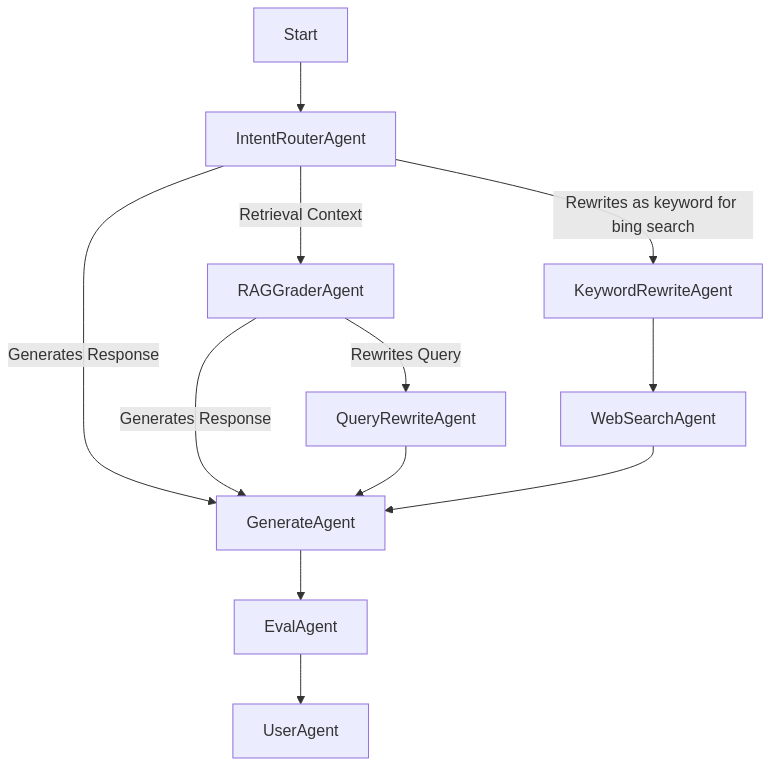

In [24]:
from azure_genai_utils.graphs import visualize_agents

agents = [
    "Start",
    "IntentRouterAgent",
    "RAGGraderAgent",
    "QueryRewriteAgent",
    "GenerateAgent",
    "EvalAgent",
    "KeywordRewriteAgent",
    "WebSearchAgent",
    "UserAgent",
]
interactions = [
    ("Start", "IntentRouterAgent"),
    ("IntentRouterAgent", "GenerateAgent", "Generates Response"),
    ("IntentRouterAgent", "RAGGraderAgent", "Retrieval Context"),
    ("IntentRouterAgent", "KeywordRewriteAgent", "Rewrites as keyword for bing search"),
    ("GenerateAgent", "EvalAgent"),
    ("EvalAgent", "UserAgent"),
    ("RAGGraderAgent", "GenerateAgent", "Generates Response"),
    ("RAGGraderAgent", "QueryRewriteAgent", "Rewrites Query"),
    ("QueryRewriteAgent", "GenerateAgent"),
    ("KeywordRewriteAgent", "WebSearchAgent"),
    ("WebSearchAgent", "GenerateAgent"),
    #("EvalAgent", "IntentRouterAgent"),
]

visualize_agents(agents, interactions)

This is an example of visualized pipeline

!["adaptive-RAG"](../../images/adaptive-RAG.png)

In [25]:
@dataclass
class Message:
    intent: str = None
    query: str = None
    context: str = None
    response: str = None
    source: str = None
    def set_source(self, source: str) -> "Message":
        self.source = source
        return self

# Topic Definition
user_query_topic_type = "UserQuery"
rag_grader_topic_type = "RagGraderAgent"
query_rewrite_topic_type = "QueryRewriteAgent"
generate_topic_type = "GenerateAgent"
eval_topic_type = "EvalAgent"
keyword_rewrite_topic_type = "KeywordRewriteAgent"
web_search_topic_type = "WebSearchAgent"
user_topic_type = "UserAgent"

query = ""

In [26]:
# This prompt provides instructions to the model
INTENT_ROUTER_PROMPT="""
                    The LLM covers casual topic such as greeting, small talks and basic information. 
                    Use the LLM for questions on IT related topics such as what is the history of microsoft, what is deep learning?, how can I learn about Gen AI.
                    The RAG contains documents related to hotel information in New York until Aug, 2024.
                    Use the RAG for questions on the hotel related topics. For all else, websearch.
                    response inent_type such as LLM, RAG, or websearch.
Query: {query}
"""

@type_subscription(topic_type=user_query_topic_type)
class IntentRouterAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("Query Rewrite Agent")
        self._system_message = SystemMessage(
            content=(
                """
                    You are an expert at routing a user question to LLM or RAG or websearch.
                """
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")

        llm_result = await self._model_client.create(
            messages=[self._system_message, 
                        UserMessage(content=INTENT_ROUTER_PROMPT.format(query=message.query), source=message.source),
                      ],
            extra_create_args={"response_format": IntentResponse},
            cancellation_token=ctx.cancellation_token,
        )
        response_content = json.loads(llm_result.content)
        print(response_content)
        
        if(response_content["intent_type"] == "LLM"):
            await self.publish_message(Message(intent=response_content["intent_type"], query=message.query, context="no context", source=message.source), topic_id=TopicId(type=generate_topic_type, source=message.source))
        elif(response_content["intent_type"] == "RAG"):    
            await self.publish_message(Message(intent=response_content["intent_type"], query=message.query, source=message.source), topic_id=TopicId(type=rag_grader_topic_type, source=message.source))
        elif(response_content["intent_type"] == "websearch"):
            await self.publish_message(Message(intent=response_content["intent_type"], query=message.query, source=message.source), topic_id=TopicId(type=keyword_rewrite_topic_type, source=message.source))

In [27]:

@type_subscription(topic_type=rag_grader_topic_type)
class RAGGraderAgent(RoutedAgent):

    def __init__(
            self, 
            azure_ai_search_endpoint:str, 
            azure_search_admin_key:str,
            index_name: str,
            retrieval_evaluator: RetrievalEvaluator,
            ) -> None:
        
        super().__init__("RAG Grader Agent")
        self.index_name = index_name
        self.azure_ai_search_endpoint = azure_ai_search_endpoint
        self.azure_search_admin_key = azure_search_admin_key
        self.retrieval_evaluator = retrieval_evaluator

    def config_search(self) -> SearchClient:
        service_endpoint = self.azure_ai_search_endpoint
        key = self.azure_search_admin_key
        index_name = self.index_name
        credential = AzureKeyCredential(key)
        return SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)

    async def do_search(self, query: str) -> str:
        """Search indexed data using Azure Cognitive Search with vector-based queries."""
        aia_search_client = self.config_search()

        fields = "descriptionVector" # TODO: Check if this is the correct field name
        # don't use exhaustive search for large indexes
        vector_query = VectorizableTextQuery(text=query, k_nearest_neighbors=1, fields=fields, exhaustive=True)
 
        search_results = aia_search_client.search(  
            search_text=query,  
            vector_queries= [vector_query],
            select=["Description,HotelName,Tags"], #TODO: Check if these are the correct field names
            top=5 #TODO: Check if this is the correct number of results
        )
        answer = "\n".join([f'{document["HotelName"]}:{document["Description"]}:{document["Tags"]}' for document in search_results])  
        return answer
    
    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        
        context_from_ai_search = await self.do_search(message.query)
        print(context_from_ai_search)

        query_response = dict(
            query=query,
            context=context_from_ai_search
        )

        retrieval_score = self.retrieval_evaluator (
            **query_response
        )

        print(f"retrieval_score: {retrieval_score['retrieval']}")
    
        if(retrieval_score["retrieval"] >= 3.0):
            await self.publish_message(Message(intent=message.intent, query=message.query, context=context_from_ai_search, source=message.source), topic_id=TopicId(type=generate_topic_type, source=message.source))
        elif(retrieval_score["retrieval"] < 3.0):
            await self.publish_message(Message(intent=message.intent, query=message.query, context=context_from_ai_search, source=message.source), topic_id=TopicId(type=query_rewrite_topic_type, source=message.source))

In [28]:
REWRITE_PROMPT="""
You a question re-writer that converts an input question to a better version that is optimized
for vectorstore retrieval. Look at the input and try to rewrite for hotel information service about the underlying semantic intent / meaning.
follow the scope of the query and don't add more additional condition. 
Query: {query}
"""

@type_subscription(topic_type=query_rewrite_topic_type)
class QueryRewriteAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("Query Rewrite Agent")
        self._system_message = SystemMessage(
            content=(
                """
                    You are an helper agent that can rewrite the query.
                """
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        print(f"\n{'-'*80}\n{message.query} received query:\n")
        llm_result = await self._model_client.create(
            messages=[self._system_message, 
                        UserMessage(content=REWRITE_PROMPT.format(query=message.query), source=message.source),
                      ],
            cancellation_token=ctx.cancellation_token,
        )
        response = llm_result.content
        print(f"Rewrite query:\n{response}")
        await self.publish_message(Message(intent=message.intent, query=response, context=message.context, source=message.source), topic_id=TopicId(type=generate_topic_type, source=message.source))

In [29]:
# This prompt provides instructions to the model
GROUNDED_PROMPT="""
Read the context carefully and answer the query in a friendly, concise, bulleted format.

Follow these rules based on the Intent:

LLM:
Provide the answer in a casual, human-like chatbot style.
Conclude with the statement: “I am saying this from my basic knowledge.”
websearch or RAG:
Use only the facts explicitly stated in the context.
Conclude with the statement: “I am saying this based on the {intent}”
If the context does not contain enough information to answer, respond with:

“I don’t know.”
Do not include any information outside the provided context.

Intent: {intent}
Query: {query}
Context:\n{context}
"""

@type_subscription(topic_type=generate_topic_type)
class GenerateAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("Generate Agent")
        self._system_message = SystemMessage(
            content=(
                """
                    You are a friendly assistant that recommends hotels based on activities and amenities.
                """
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        llm_result = await self._model_client.create(
            messages=[self._system_message, 
                UserMessage(content=GROUNDED_PROMPT.format(intent=message.intent, query=message.query, context=message.context), source=message.source),
                  ],
                  extra_create_args={"response_format": RecommendationList} if message.intent == "RAG" else {},
            cancellation_token=ctx.cancellation_token,
        )

        response_content = llm_result.content

        print(f"Generated response:\n{response_content}")
        if(message.intent == "LLM"):
            await self.publish_message(AssistantMessage(content=response_content, source=message.source), topic_id=TopicId(type=user_topic_type, source=message.source))
        else:
            await self.publish_message(Message(intent=message.intent, query=message.query, context=message.context, response=response_content, source=message.source), topic_id=TopicId(type=eval_topic_type, source=message.source))

In [30]:
INCORRECT_ANSWER="""
Hello, and thank you for bringing this to our attention! I may have provided an inaccurate or misleading response, and I sincerely apologize for the confusion.
As an AI, I aim to deliver helpful and accurate information, but sometimes I might misinterpret or generate an incorrect response. Your feedback is invaluable and helps me improve.

If you'd like, feel free to share more details or clarify your question, and I’ll do my best to assist you further. Thank you for your understanding and patience! 😊
"""

@type_subscription(topic_type=eval_topic_type)
class EvalAgent(RoutedAgent):

    def __init__(
            self, 
            groundedness_evaluator: GroundednessEvaluator,
            relevance_evaluator: RelevanceEvaluator,
            ) -> None:
        
        super().__init__("Eval Agent")
        self.groundedness_evaluator = groundedness_evaluator
        self.relevance_evaluator = relevance_evaluator

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        query_response = dict(
            query=message.query,
            context=message.context,
            response=message.response
            
        )

        groundedness_score = self.groundedness_evaluator (
            **query_response
        )
        print(f"groundness_score: {groundedness_score['groundedness']}")
        if(groundedness_score["groundedness"] < 3.0):
            await self.publish_message(AssistantMessage(content=INCORRECT_ANSWER, source=message.source), topic_id=TopicId(type=user_topic_type, source=message.source))
        relevance_score = self.relevance_evaluator (
            **query_response
        )
        
        print(f"relevance_score: {relevance_score['relevance']}")
        if(relevance_score["relevance"] >= 3.0):
            await self.publish_message(AssistantMessage(content=message.response, source=message.source), topic_id=TopicId(type=user_topic_type, source=message.source))
        elif(relevance_score["relevance"] < 3.0):
            await self.publish_message(AssistantMessage(content=INCORRECT_ANSWER, source=message.source), topic_id=TopicId(type=user_topic_type, source=message.source))
        

In [31]:
KEYWORD_REWRITE_PROMPT="""
You a keyword re-writer that converts an input question to a better version that is optimized for search. 
Generate search keyword from a user query 
to be more specific, detailed, and likely to retrieve relevant information, allowing for a more accurate response through web search.
Don't include the additional context from the user question.

Query: {query}
Revised web search query:
"""

@type_subscription(topic_type=keyword_rewrite_topic_type)
class KeywordRewriteAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("Query Rewrite Agent")
        self._system_message = SystemMessage(
            content=(
                """
                    You are an helper agent that can rewrite the query.
                """
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        llm_result = await self._model_client.create(
            messages=[self._system_message, 
                        UserMessage(content=KEYWORD_REWRITE_PROMPT.format(query=message.query), source=message.source),
                      ],
            cancellation_token=ctx.cancellation_token,
        )
        response = llm_result.content
        
        await self.publish_message(Message(intent=message.intent, query=response, context=message.context, source=message.source), topic_id=TopicId(type=web_search_topic_type, source=message.source))

In [32]:
INCORRECT_ANSWER="""
Hello, and thank you for bringing this to our attention! I may have provided an inaccurate or misleading response, and I sincerely apologize for the confusion.
As an AI, I aim to deliver helpful and accurate information, but sometimes I might misinterpret or generate an incorrect response. Your feedback is invaluable and helps me improve.

If you'd like, feel free to share more details or clarify your question, and I’ll do my best to assist you further. Thank you for your understanding and patience! 😊
"""

@type_subscription(topic_type=web_search_topic_type)
class WebSearchAgent(RoutedAgent):

    def __init__(
            self, 
            web_search_tool: BingSearch,
            retrieval_evaluator: RetrievalEvaluator,
            ) -> None:
        
        super().__init__("WebSearch Agent")
        self.web_search_tool = web_search_tool
        self.retrieval_evaluator = retrieval_evaluator

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        search_results = web_search_tool.invoke({"query": message.query})
        print(search_results)
        try:
            contents = []
            items = list(search_results)
            for i in range(min(5, len(items))):
                doc = items[i]
                contents.append(doc.get("content", "No content"))
            content = "\n".join(contents)
        except Exception as e:
            print(f"Error: {e}")
            content = "No content"
        
        print("================================ search results ================================")
        print(content)

        search_response = dict(
            query=message.query,
            context=content
            
        )

        retrieval_score = self.retrieval_evaluator (
            **search_response
        )
        print(f"retrieval_score: {retrieval_score['retrieval']}")
        
        if(retrieval_score["retrieval"] >= 3.0):
            await self.publish_message(Message(intent=message.intent, query=message.query, context=content, source=message.source), topic_id=TopicId(type=generate_topic_type, source=message.source))
        elif(retrieval_score["retrieval"] < 2.0):
            await self.publish_message(AssistantMessage(content=INCORRECT_ANSWER, source=message.source), topic_id=TopicId(type=user_topic_type, source=message.source))
        

In [33]:
def is_valid_json(data: str) -> bool:
    if not isinstance(data, str):
        return False
    data = data.strip()
    if not data:
        return False
    if not (data.startswith("{") or data.startswith("[")):  
        return False
    
@type_subscription(topic_type=user_topic_type)
class UserAgent(RoutedAgent):
    def __init__(self) -> None:
        super().__init__("A user agent that outputs the final copy to the user.")

    @message_handler
    async def handle_final_copy(self, message: AssistantMessage, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received a message:\n")
        
        if(is_valid_json(message.content)):
            response_content = json.loads(message.content)
            for recommendation in response_content['recommendation']:
                print(recommendation)
        else:
            print(message.content)

<br>

## 🧪 Step 3. Execute the Workflow
---

### Execute the workflow

In [34]:
runtime = SingleThreadedAgentRuntime()

await IntentRouterAgent.register(runtime, type=user_query_topic_type, factory=lambda: IntentRouterAgent(model_client=autogen_aoai_client))

await RAGGraderAgent.register(runtime, type=rag_grader_topic_type, factory=lambda: RAGGraderAgent(
    azure_ai_search_endpoint=azure_ai_search_endpoint,
    azure_search_admin_key=azure_search_admin_key,
    index_name=index_name,
    retrieval_evaluator=RetrievalEvaluator(model_config),
    ))

await QueryRewriteAgent.register(runtime, type=query_rewrite_topic_type, factory=lambda: QueryRewriteAgent(model_client=autogen_aoai_client))

await GenerateAgent.register(runtime, type=generate_topic_type, factory=lambda: GenerateAgent(model_client=autogen_aoai_client))

await EvalAgent.register(runtime, type=eval_topic_type, factory=lambda: EvalAgent(
    groundedness_evaluator=GroundednessEvaluator(model_config),
    relevance_evaluator=RelevanceEvaluator(model_config),
    ))

WEB_SEARCH_FORMAT_OUTPUT = False

await KeywordRewriteAgent.register(runtime, type=keyword_rewrite_topic_type, factory=lambda: KeywordRewriteAgent(model_client=autogen_aoai_client))

await WebSearchAgent.register(runtime, type=web_search_topic_type, factory=lambda: WebSearchAgent(
    web_search_tool=BingSearch(
        max_results=3,
        locale="en-US",
        include_news=False,
        include_entity=False,
        format_output=WEB_SEARCH_FORMAT_OUTPUT,
    ),
    retrieval_evaluator=RetrievalEvaluator(model_config),
    ))


await UserAgent.register(runtime, type=user_topic_type, factory=lambda: UserAgent())

AgentType(type='UserAgent')

In [37]:
import time

start_time = time.perf_counter()

runtime.start()

#await runtime.publish_message(Message(query="what is the history of Microsoft?", source="User"), topic_id=TopicId(type=user_query_topic_type, source="user"))
#await runtime.publish_message(Message(query="can you recommend a hoels", source="User"), topic_id=TopicId(type=user_query_topic_type, source="user"))
await runtime.publish_message(Message(query="can you recommend some hotels with free wifi?", source="User"), topic_id=TopicId(type=user_query_topic_type, source="user"))
#await runtime.publish_message(Message(query="can you tell me openning hotels in NY 2025?", source="User"), topic_id=TopicId(type=user_query_topic_type, source="user"))

await runtime.stop_when_idle()


end_time = time.perf_counter()
print(f"Elapsed time: {end_time - start_time} seconds")


--------------------------------------------------------------------------------
UserQuery received a message:



{'intent_type': 'RAG'}

--------------------------------------------------------------------------------
RagGraderAgent received a message:

Friendly Motor Inn:Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi.:['24-hour front desk service', 'continental breakfast', 'free wifi']
Double Sanctuary Resort:5 star Luxury Hotel - Biggest Rooms in the city. #1 Hotel in the area listed by Traveler magazine. Free WiFi, Flexible check in/out, Fitness Center & espresso in room.:['view', 'pool', 'restaurant', 'bar', 'continental breakfast']
Starlight Suites:Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV:['pool', 'coffee in lobby', 'free wifi']
Countryside Hotel:Save up to 50% off traditional hotels. Free WiFi, great location near downtown, full kitchen, washer & dryer, 24/7 support, bowling alley, f